In [13]:
from IPython.display import display, HTML
display(HTML ("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}""
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

**<font size='6' color='red'>ch5_Lstm(영화평감상분석)</font>**
- imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수: 부정/긍정

# 1. 패키지 import

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남

In [102]:
MY_WORDS = 20000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200 # 독립변수 차원(영화평 단어수 80개로 맞출 예정)
MY_EMBED = 32 # Embedding 결과 차원
MY_HIDDEN = 64 # LSTM의 units 수

MY_EPOCH = 15 # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터수)

# 불용어 설정(빈도수가 높은 상위 1~20은 대부분 the, a, is...)
SKIP_TOP = 30

# 3. 데이터 불러오기

In [103]:
(X_train, y_train), (X_test, y_test)=imdb.load_data(num_words=MY_WORDS, # 1~MY_WORDS 이외는 2로 가져옴 
                                                    skip_top=SKIP_TOP) # 1~20까지를 2로 가져옴

In [18]:
print('학습용 독립변수 모양:', X_train.shape)
print('학습용 타겟변수 모양:', y_train.shape)
print('학습용 독립변수 샘플:', X_train[0][:80])
print('학습용 타겟변수(0:부정/1:긍정) 샘플:', y_train[0])
print('테스트용 독립변수 모양:', X_test.shape)
print('테스트용 타겟변수 모양:', y_test.shape)

학습용 독립변수 모양: (25000,)
학습용 타겟변수 모양: (25000,)
학습용 독립변수 샘플: [2, 2, 22, 2, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 2, 173, 36, 256, 2, 25, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 2, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2, 2, 2, 22, 2, 2, 2, 469, 2, 22, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 2, 2, 22, 2]
학습용 타겟변수(0:부정/1:긍정) 샘플: 1
테스트용 독립변수 모양: (25000,)
테스트용 타겟변수 모양: (25000,)


In [19]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [20]:
# 긍정 갯수
print('학습데이터의 긍정 갯수:',y_train.sum())
print('테스트데이터의 긍정 갯수:', y_test.sum())

학습데이터의 긍정 갯수: 12500
테스트데이터의 긍정 갯수: 12500


# 4. 문자단어 -> 정수

In [88]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) (빈도가 높은 단어 앞)
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))
# SKIP_TOP 값을 고민하기 위해 최빈 단어(현재 SKIP_TOP값 20)
print([id_to_word[i] for i in range(1, 18)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie']


In [89]:
msg = "What a wonderful movie"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자 2: MY_WORD(10000)이내에 들어가지 않는 단어, 3: padding 처리
data = [1]+[word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용:', msg)
print('encoded된 내용:', data)
data = [d if d>30 else 2 for d in data]
print('SKIP_TOP 처리할 경우 :', data)
print('data 추정:', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movie']
원 후기 내용: ['what', 'a', 'wonderful', 'movie']
encoded된 내용: [1, 51, 6, 389, 20]
SKIP_TOP 처리할 경우 : [2, 51, 2, 389, 2]
data 추정: ??? what ??? wonderful ???


In [90]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', '???', 'wonderful', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [104]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    for num in review_nums:
        word = id_to_word.get(num-3,'???')
        decoded.append(word)
    print(' '.join(decoded))

In [32]:
print(X_test[0])
print(decoding(X_test[0]))

[2, 591, 202, 2, 31, 2, 717, 2, 2, 2, 2, 2, 2, 360, 2, 2, 177, 2, 394, 354, 2, 123, 2, 2, 2, 2, 2, 2, 2, 92, 124, 89, 488, 2, 100, 28, 2, 2, 31, 23, 27, 2, 29, 220, 468, 2, 124, 2, 286, 170, 2, 157, 46, 2, 27, 239, 2, 179, 2, 38, 32, 25, 2, 451, 202, 2, 2, 717]
??? please give ??? one ??? miss ??? ??? ??? ??? ??? ??? rest ??? ??? cast ??? terrible performances ??? show ??? ??? ??? ??? ??? ??? ??? don't know how michael ??? could have ??? ??? one on his ??? he almost seemed ??? know ??? wasn't going ??? work out ??? his performance ??? quite ??? so all you ??? fans give ??? ??? miss
None


In [92]:
decoding(X_train[0]), y_train[0]

??? ??? ??? ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? ??? ??? ??? ??? throughout ??? ??? were great ??? ??? just brilliant so much ??? ??? ??? ??? ??? ??? soon ??? ??? ??? released ??? ??? ??? would recommend ??? ??? everyone ??? watch ??? ??? ??? ??? ??? amazing really ??? at ??? end ??? ??? so sad ??? ??? know what they say if ??? ??? at ??? ??? ??? must ??? been good ??? ??? definitely ??? also ??? ??? ??? two little ??? ??? played ??? ??? ??? ??? ??? paul they were just brilliant children ??? often left out ??? ??? ??? ??? ??? think because ??? stars ??? play them all ??? up ??? such ??? big ??? ??? ??? whole ??? ??? these children ??? amazing ??? should be ??? ??? what they ??? done don't ??? think ??? whole story ??? so ??? because ??

(None, 1)

# 6. 영화평 학습용 데이터

In [105]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이: {len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [106]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [107]:
# X_train 후기 중 가장 긴 단어 수, 가장 짧은 단어 수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [108]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)
- post 짜르기, post 붙이기 : 0.7603600025177002
- pre짜르기, pre붙이기 : 0.79448002576828
- post짜르기, pre붙이기 : 0.7619600296020508
- pre 짜르기, post 붙이기 : 0.8000800013542175

In [109]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       #truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       truncating='pre' ,
                       padding='post',
                       #padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       #truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       truncating='pre' ,
                       padding='post',
                       #padding='pre' 
                    )
show_length()

첫 20개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


# 8. 최종 데이터 shape 확인

In [110]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [111]:
decoding(X_train[0])

??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same scottish island ??? myself so ??? loved ??? fact there ??? ??? real connection ??? ??? ??? ??? witty remarks throughout ??? ??? were great ??? ??? just brilliant so much ??? ??? bought ??? ??? ??? soon ??? ??? ??? released ??? retail ??? would recommend ??? ??? everyone ??? watch ??? ??? fly fishing ??? amazing really cried at ??? end ??? ??? so sad ??? ??? know what they say if ??? cry at ??? ??? ??? must ??? been good ??? ??? definitely ??? also congratulations ??? ??? two little boy's ??? played ??? ??? ??? norman ??? paul they were just brilliant children ??? often left out ??? ??? praising list ??? think because ??? stars ??? play them all grown up ??? such ??? big profile ??? ??? whole ??? ??? these children ??? amazing ??? should be praised ??? what they ??? done don't ??? think ??? whole story ??? so lovely because ??? ??? true ??? ??? someone's l

# 9. 모델 생성 및 구현

In [112]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, # 10000
                   output_dim=MY_EMBED, # 32
                   input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.5, #이전 0.1~0.5 각 스텝마다 LSTM셀로 들어가는 연결 30% 0으로
               recurrent_dropout=0.3 # 0.1~0.3 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
              #input_shape =(MY_LENGTH, MY_EMBED),
              #kernel_initializer='he_normal', # 입력 가중치 초기화
              #recurrent_initializer= 'orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 32)           640000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [113]:
model.compile(loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
             optimizer='adam',
             metrics=['accuracy'])
start = time() # 70.1.1 ~ 이 시점까지 초수
earlyStopping = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1,
                callback=[earlyStopping])
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 33s 316ms/step - loss: 0.6905 - accuracy: 0.5196 - val_loss: 0.6865 - val_accuracy: 0.5310
Epoch 2/15
100/100 [==============================] - 35s 346ms/step - loss: 0.5855 - accuracy: 0.6763 - val_loss: 0.3595 - val_accuracy: 0.8540
Epoch 3/15
100/100 [==============================] - 35s 351ms/step - loss: 0.3147 - accuracy: 0.8824 - val_loss: 0.3218 - val_accuracy: 0.8678
Epoch 4/15
100/100 [==============================] - 35s 354ms/step - loss: 0.2235 - accuracy: 0.9207 - val_loss: 0.3721 - val_accuracy: 0.8790
Epoch 5/15
100/100 [==============================] - 35s 353ms/step - loss: 0.1744 - accuracy: 0.9417 - val_loss: 0.3255 - val_accuracy: 0.8846
Epoch 6/15
100/100 [==============================] - 35s 351ms/step - loss: 0.1408 - accuracy: 0.9545 - val_loss: 0.3937 - val_accuracy: 0.8834
Epoch 7/15
100/100 [==============================] - 35s 353ms/step - loss: 0.1233 - accuracy: 0.9605 - val_loss: 0.3410 - val_ac

# 11. 모델평가

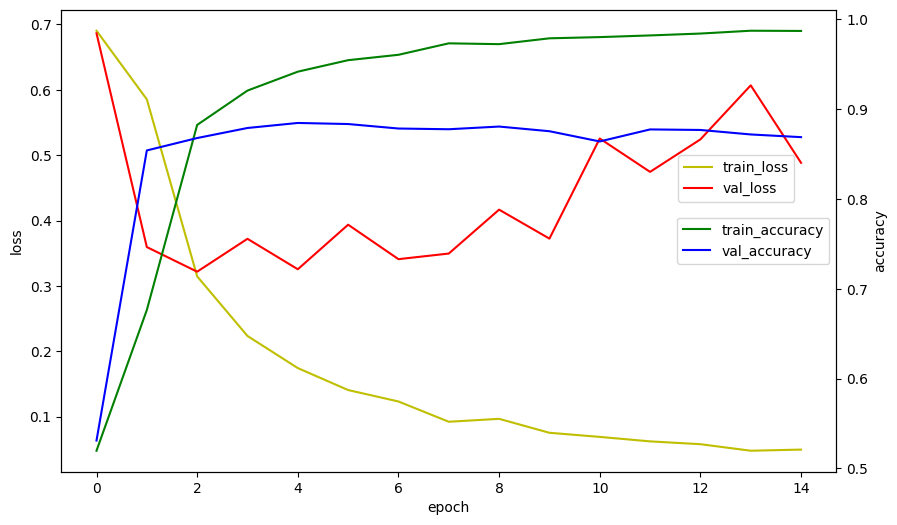

In [114]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [115]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도:', acc)

test의 데이터 정확도: 0.8497200012207031


In [54]:
# 모델 저장
model.save('imdb_v2.10_skiptop20length80.h5')

In [60]:
#혼동행렬(교차표, 평가성능지표)
#y_test # 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int) # 예측값
#y_hat 

782/782 [==============================] - 4s 6ms/step


array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [62]:
y_test.shape, y_hat.shape

((25000,), (25000, 1))

In [63]:
# 실제값(1차원)과 예측값(2차원)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[10168,  2332],
       [ 2222, 10278]], dtype=int64)

In [66]:
# 실제값과 예측값의 차원이 1차원
ctab = pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])
ctab['0확률'] = [ctab.loc[0,0]/25000*100, ctab.loc[1,0]/25000*100]
ctab['1확률'] = [ctab.loc[0,1]/25000*100, ctab.loc[1,1]/25000*100]
ctab

예측값,0,1,0확률,1확률
실제값,,,,
0,10168,2332,40.672,9.328
1,2222,10278,8.888,41.112


In [70]:
# accuracy, precision, recall, f1_score
print('acc:', acc)
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test,y_hat))
print('f1_score:',f1_score(y_test,y_hat))

acc: 0.8178399801254272
precision: 0.8150674068199841
recall: 0.82224
f1_score: 0.818637992831541


In [81]:
import re
review = """Train Dreams is a quiet, beautifully crafted film that lingers long after it ends. 
Joel Edgerton delivers one of his most subtle and moving performances, portraying a man shaped by loss, memory, and the changing American landscape. 
The cinematography is stunning, turning forests and railways into poetic reflections of time and grief.
It’s slow and meditative, but for those who appreciate emotionally rich, atmospheric storytelling, Train Dreams is a small masterpiece.
""".lower()
review= re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.split()
print(review)
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
encoded = [e if (e<=20) & (e<1000) else 2 for e in encoded] # skip_top 사용시 
print(encoded, len(encoded))

['train', 'dreams', 'is', 'a', 'quiet', 'beautifully', 'crafted', 'film', 'that', 'lingers', 'long', 'after', 'it', 'ends', 'joel', 'edgerton', 'delivers', 'one', 'of', 'his', 'most', 'subtle', 'and', 'moving', 'performances', 'portraying', 'a', 'man', 'shaped', 'by', 'loss', 'memory', 'and', 'the', 'changing', 'american', 'landscape', 'the', 'cinematography', 'is', 'stunning', 'turning', 'forests', 'and', 'railways', 'into', 'poetic', 'reflections', 'of', 'time', 'and', 'grief', 'it', 's', 'slow', 'and', 'meditative', 'but', 'for', 'those', 'who', 'appreciate', 'emotionally', 'rich', 'atmospheric', 'storytelling', 'train', 'dreams', 'is', 'a', 'small', 'masterpiece']
[2, 2, 2, 2, 2, 2, 2, 2, 22, 2, 2, 196, 103, 2, 630, 2, 2, 2, 31, 2, 27, 91, 2, 2, 728, 354, 2, 2, 132, 2, 34, 2, 2, 2, 2, 2, 298, 2, 2, 627, 2, 2, 2, 2, 2, 2, 83, 2, 2, 2, 58, 2, 2, 2, 590, 550, 2, 2, 21, 2, 148, 37, 2, 2, 2, 2, 2, 2, 2, 2, 2, 392, 991] 73


In [82]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       #truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       truncating='pre' ,
                       padding='post',
                     #padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )

In [83]:
(model.predict(input_data) >0.5).astype('int8')

1/1 [==============================] - 0s 20ms/step


array([[1]], dtype=int8)

In [84]:
review="""This movie is an absolute disaster, a painful mess that fails on every possible level. 
The plot wanders without purpose, as if the writers gave up halfway and hoped no one would notice. 
The acting is wooden and lifeless, making even dramatic moments feel unintentionally funny. 
The visuals look cheap, the editing is chaotic, and the dialogue is so embarrassingly bad it almost feels like a prank. Every scene drags on endlessly, 
testing the audience’s patience. By the time the credits roll, you’re left wondering how something this poorly made ever reached the screen. Avoid it at all costs.
"""
review= re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.split()
print(review)
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
encoded = [2 if (e<=20) | (e>1000) else e for e in encoded] # skip_top 사용시 
print(encoded, len(encoded))

['This', 'movie', 'is', 'an', 'absolute', 'disaster', 'a', 'painful', 'mess', 'that', 'fails', 'on', 'every', 'possible', 'level', 'The', 'plot', 'wanders', 'without', 'purpose', 'as', 'if', 'the', 'writers', 'gave', 'up', 'halfway', 'and', 'hoped', 'no', 'one', 'would', 'notice', 'The', 'acting', 'is', 'wooden', 'and', 'lifeless', 'making', 'even', 'dramatic', 'moments', 'feel', 'unintentionally', 'funny', 'The', 'visuals', 'look', 'cheap', 'the', 'editing', 'is', 'chaotic', 'and', 'the', 'dialogue', 'is', 'so', 'embarrassingly', 'bad', 'it', 'almost', 'feels', 'like', 'a', 'prank', 'Every', 'scene', 'drags', 'on', 'endlessly', 'testing', 'the', 'audience', 's', 'patience', 'By', 'the', 'time', 'the', 'credits', 'roll', 'you', 're', 'left', 'wondering', 'how', 'something', 'this', 'poorly', 'made', 'ever', 'reached', 'the', 'screen', 'Avoid', 'it', 'at', 'all', 'costs']
[2, 2, 2, 2, 35, 2, 2, 2, 2, 947, 2, 996, 23, 175, 614, 651, 2, 114, 2, 209, 2, 2, 48, 2, 927, 520, 56, 2, 2, 2, 57,

In [85]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       #truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       truncating='pre' ,
                       padding='post',
                     #padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
(model.predict(input_data) >0.5).astype('int8')

1/1 [==============================] - 0s 20ms/step


array([[0]], dtype=int8)